# Predictive Maintenance Project

The objective of this project is to develop a predictive maintenance model that can identify early warning signs of machine failure using sensor data. By leveraging historical operational data, the goal is to predict potential failures before they occur to enable proactive maintenance decisions. This helps reduce unplanned downtime, optimize maintenance scheduling, and improve overall equipment efficiency. In addition to predictive modeling, the project aims to interpret model behavior through techniques such as SHAP analysis to understand which features most influence predictions and to ensure that insights are both data-driven and interpretable for engineering validation.

In [ ]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, PrecisionRecallDisplay, average_precision_score
import shap

%matplotlib inline

## Exploratory Data Analysis

In [ ]:
path = '~/Predictive_Maintenance_Project/'

In [4]:
maintenance_data = pd.read_csv(path + 'raw_data/ai4i2020.csv')
maintenance_data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
# Drop irrelevant data
cleaned_data = maintenance_data.drop(['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis = 1)
cleaned_data.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [6]:
# Rename columns
cleaned_data.columns = cleaned_data.columns.str.lower().str.replace(r"\s\[.*?\]","", regex=True).str.replace(r"\s+", "_", regex=True)
cleaned_data.head()

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [7]:
# Check data types and missing values
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type                 10000 non-null  object 
 1   air_temperature      10000 non-null  float64
 2   process_temperature  10000 non-null  float64
 3   rotational_speed     10000 non-null  int64  
 4   torque               10000 non-null  float64
 5   tool_wear            10000 non-null  int64  
 6   machine_failure      10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


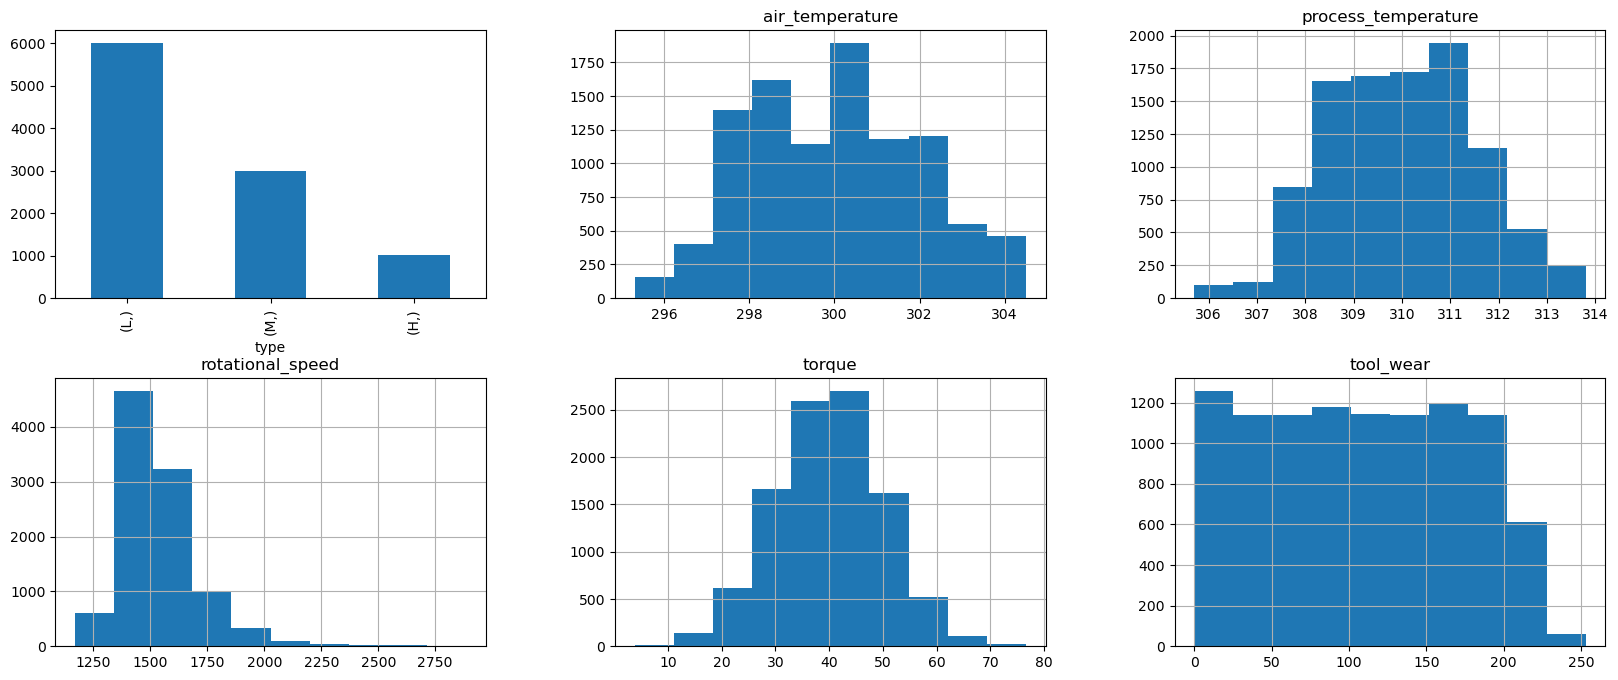

In [ ]:
# Check distribution
str_colnames = cleaned_data.select_dtypes('object').columns.to_list()
num_colnames = cleaned_data.select_dtypes('int').columns.drop('machine_failure').to_list()
num_colnames.extend(cleaned_data.select_dtypes('float').columns.to_list())

fig = plt.figure(figsize=(20, 8))
for i, col in enumerate(cleaned_data.drop('machine_failure', axis = 1).columns):
    ax = fig.add_subplot(2, 3, i+1)
    if col in str_colnames:
        cleaned_data[[col]].value_counts().plot.bar()
    elif col in num_colnames:
        cleaned_data.hist(column = col, ax = ax)
    else:
        pass
plt.show()

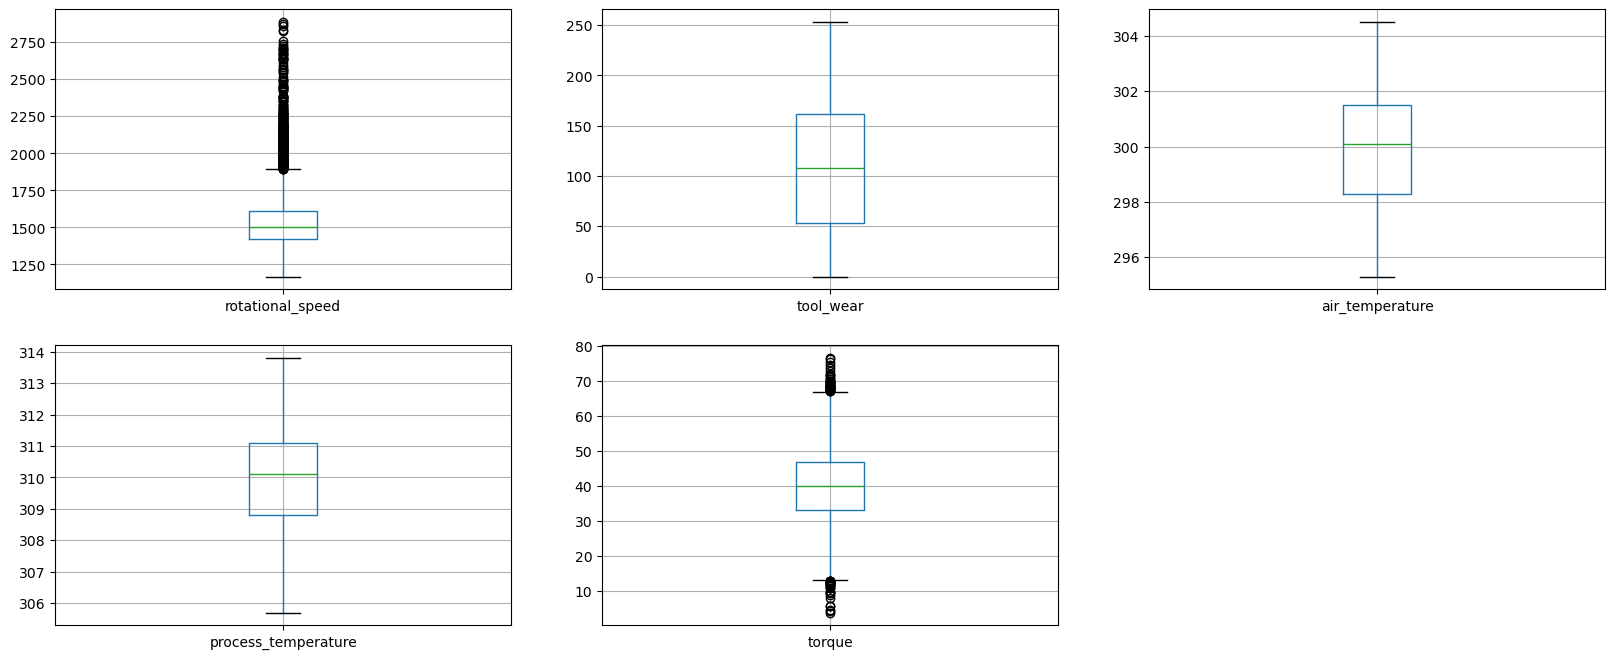

In [9]:
fig = plt.figure(figsize=(20, 8))
for i, col in enumerate(num_colnames):
    ax = fig.add_subplot(2, 3, i + 1)
    cleaned_data.boxplot(column = col, ax = ax)
plt.show()

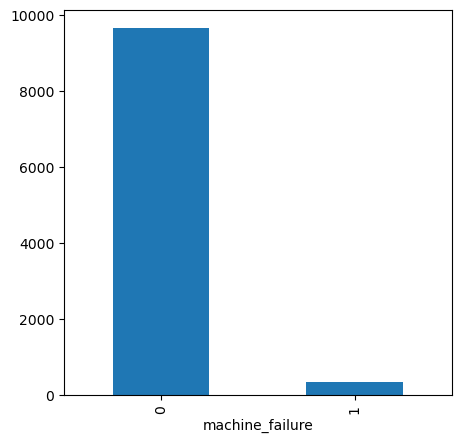

In [ ]:
# Check class sizes
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
cleaned_data.machine_failure.value_counts().plot.bar()
plt.show()

In [11]:
# Check duplication
cleaned_data[cleaned_data.duplicated()]

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure


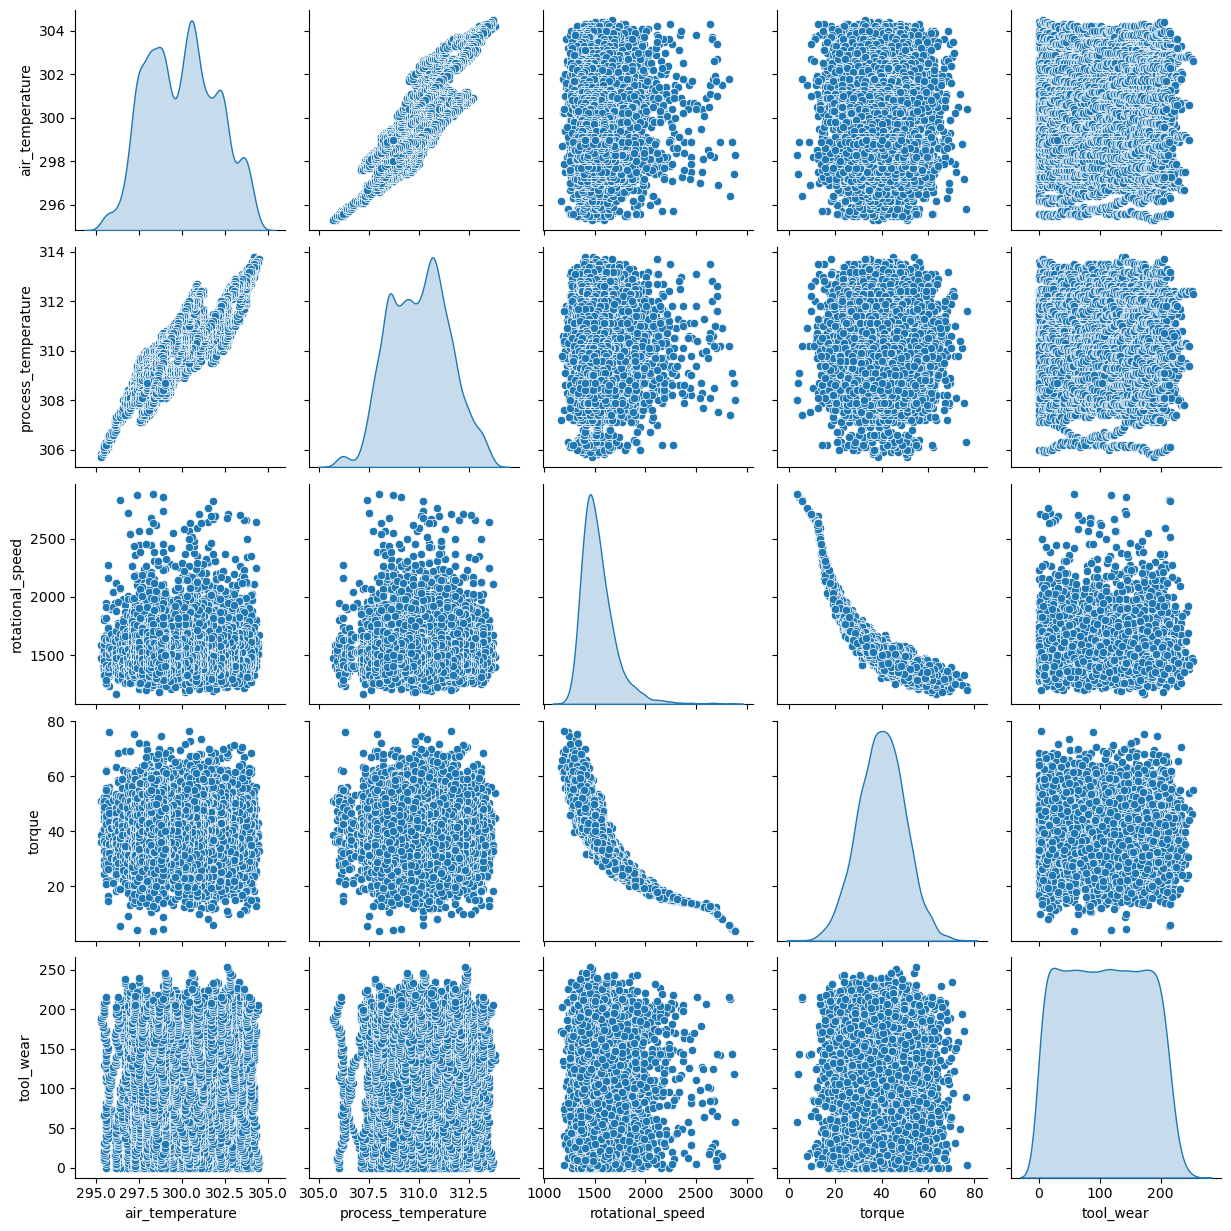

In [12]:
# Check collinearity
sns.pairplot(cleaned_data.drop(['machine_failure'], axis = 1), diag_kind = 'kde')

In the exploratory data analysis phase, I began by cleaning the dataset — removing irrelevant columns and renaming fields for better readability. Missing values and duplicate records were then checked to ensure data quality. To understand the data distribution, features were visualized using histograms and boxplots, which also helped identify potential outliers. The target variable, `machine_failure`, was found to be highly imbalanced, with far fewer failure cases compared to normal operations. Additionally, correlation analysis showed that process temperature is closely related to air temperature, and torque is strongly correlated with rotational speed.

## Data Preprocessing

In [ ]:
# Encoding type variable
ordinal_encode_mapper = {'L':1, 'M':2, 'H':3}
cleaned_data.type = cleaned_data.type.map(ordinal_encode_mapper)
cleaned_data

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure
0,2,298.1,308.6,1551,42.8,0,0
1,1,298.2,308.7,1408,46.3,3,0
2,1,298.1,308.5,1498,49.4,5,0
3,1,298.2,308.6,1433,39.5,7,0
4,1,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,0
9996,3,298.9,308.4,1632,31.8,17,0
9997,2,299.0,308.6,1645,33.4,22,0
9998,3,299.0,308.7,1408,48.5,25,0


In [15]:
def add_outlier_flag(df, col):
    df_flag = df.copy()

    q1 = df[[col]].quantile(0.25)
    q3 = df[[col]].quantile(0.75)
    IQR = q3 - q1
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    flag_col = f"is_{col}_outlier"
    df_flag[flag_col] = ((df_flag[[col]] < lower_bound) | (df_flag[[col]] > upper_bound)).astype(int)

    return(df_flag)

model_data = cleaned_data.copy()
model_data = add_outlier_flag(model_data, 'torque')
model_data = add_outlier_flag(model_data, 'rotational_speed')
model_data.head()

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,machine_failure,is_torque_outlier,is_rotational_speed_outlier
0,2,298.1,308.6,1551,42.8,0,0,0,0
1,1,298.2,308.7,1408,46.3,3,0,0,0
2,1,298.1,308.5,1498,49.4,5,0,0,0
3,1,298.2,308.6,1433,39.5,7,0,0,0
4,1,298.2,308.7,1408,40.0,9,0,0,0


In [ ]:
model_data['temp_diff'] = model_data['process_temperature'] - model_data['air_temperature']
model_data['torque_per_speed'] = model_data['torque'] / model_data['rotational_speed']
model_data.drop(['air_temperature', 'process_temperature', 'rotational_speed', 'torque'], axis = 1, inplace = True)
model_data = model_data[['type', 'tool_wear', 'is_torque_outlier', 'is_rotational_speed_outlier', 'temp_diff', 'torque_per_speed', \
                         'machine_failure']]
model_data.head()

,type,tool_wear,is_torque_outlier,is_rotational_speed_outlier,temp_diff,torque_per_speed,machine_failure
0,2,0,0,0,10.5,0.027595,0
1,1,3,0,0,10.5,0.032884,0
2,1,5,0,0,10.4,0.032977,0
3,1,7,0,0,10.4,0.027565,0
4,1,9,0,0,10.5,0.028409,0


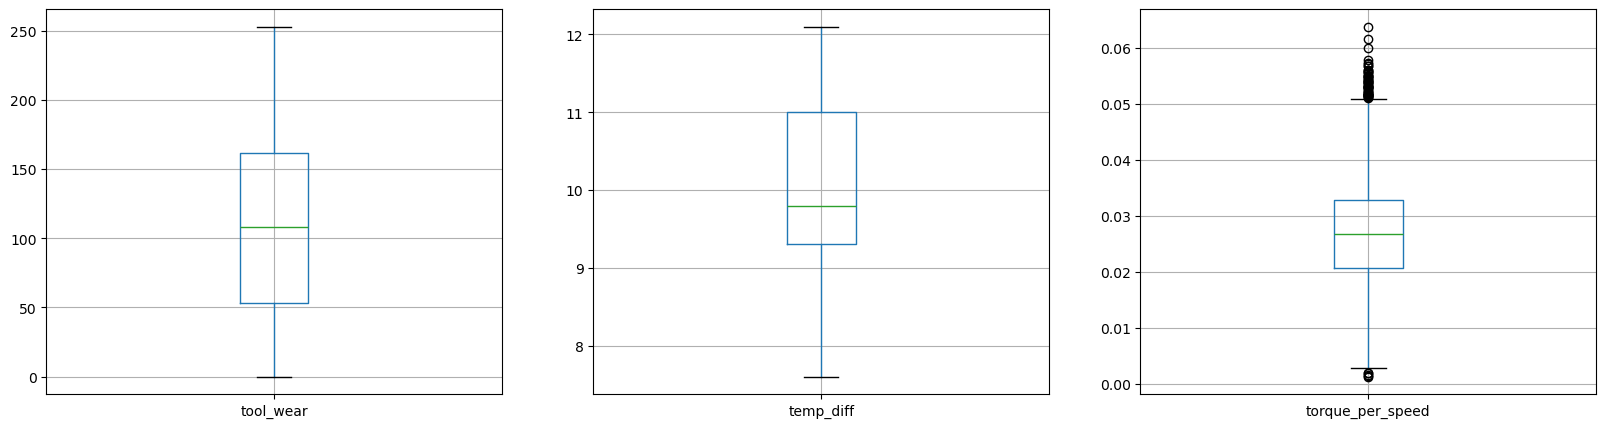

In [17]:
fig = plt.figure(figsize=(20, 5))
for i, col in enumerate(['tool_wear', 'temp_diff', 'torque_per_speed']):
    ax1 = fig.add_subplot(1, 3, i + 1)
    model_data.boxplot(column = col, ax = ax1)
plt.show()

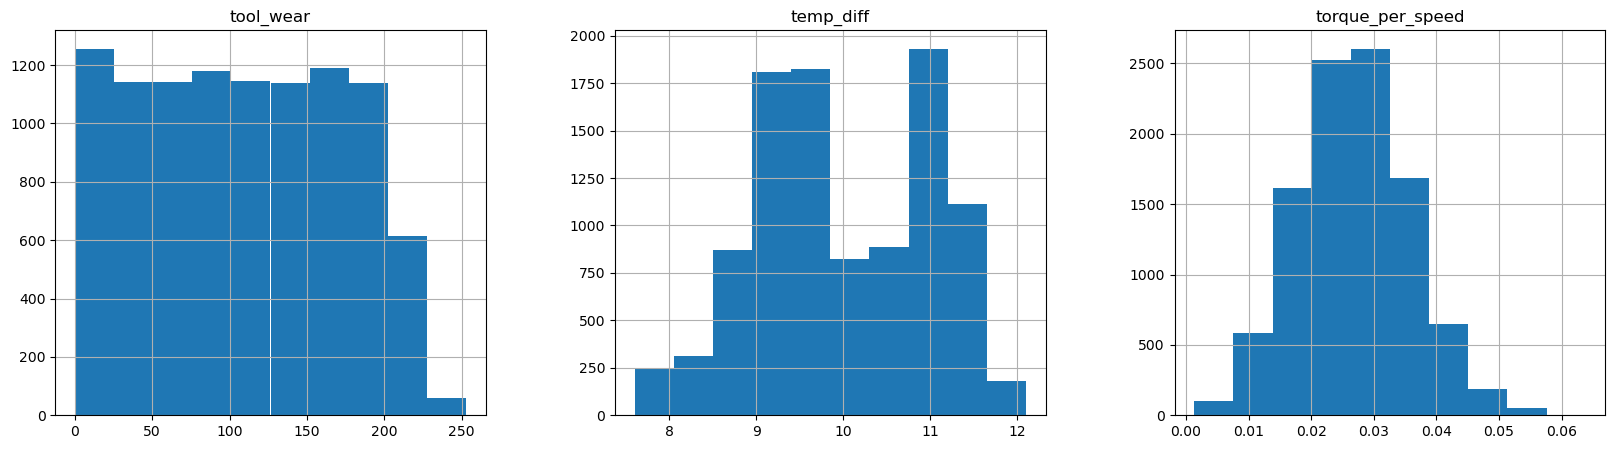

In [18]:
fig = plt.figure(figsize=(20, 5))
for i, col in enumerate(['tool_wear', 'temp_diff', 'torque_per_speed']):
    ax1 = fig.add_subplot(1, 3, i + 1)
    model_data.hist(column = col, ax = ax1)
plt.show()

During data preprocessing, the categorical variable `Type` was encoded using an ordinal mapping to preserve its inherent order. Outliers in `torque` and `rotational_speed` were flagged instead of capped or removed, as these extreme values could represent meaningful failure events rather than noise. Capping them could also obscure important patterns in derived features.

To address potential multicollinearity, two new variables were created: `temp_diff` (the difference between process and air temperature) and `torque_per_speed` (the ratio of torque to rotational speed). Although Random Forest model is generally robust to multicollinearity, these transformations were applied to ensure fair comparison with the baseline logistic regression model.

Outlier analysis was also conducted for the newly created variables. While `torque_per_speed` exhibited some extreme values, different strategies were used depending on the model: outliers were capped for the logistic regression model, which is sensitive to extreme values, and flagged for the Random Forest model, which is robust to outliers.

## Model Development

In [19]:
# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(model_data.drop(['machine_failure'], axis = 1),
                                                    model_data['machine_failure'],
                                                    stratify = model_data['machine_failure'],
                                                    random_state = 42)
print('train_size:', X_train.shape[0], '\n'
      'test_size:', y_test.shape[0])

train_size: 7500 
test_size: 2500


### Baseline Model (Logistic Regression)

<Axes: >

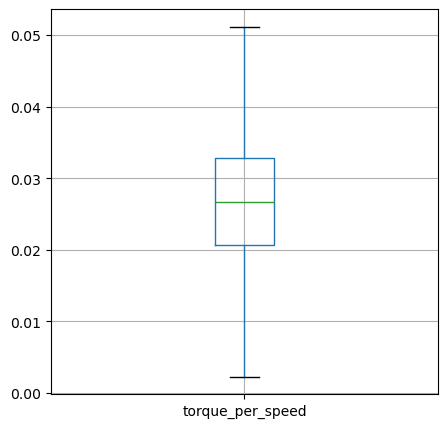

In [20]:
# Cap outliers
def cap_outliers(df, col):
    df_capped = df.copy()
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1
    
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    df_capped[col] = df_capped[col].clip(lower = lower_bound, upper = upper_bound)
    return df_capped

X_train_logistic = cap_outliers(X_train, 'torque_per_speed')

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
X_train_logistic.boxplot(column = 'torque_per_speed', ax = ax)


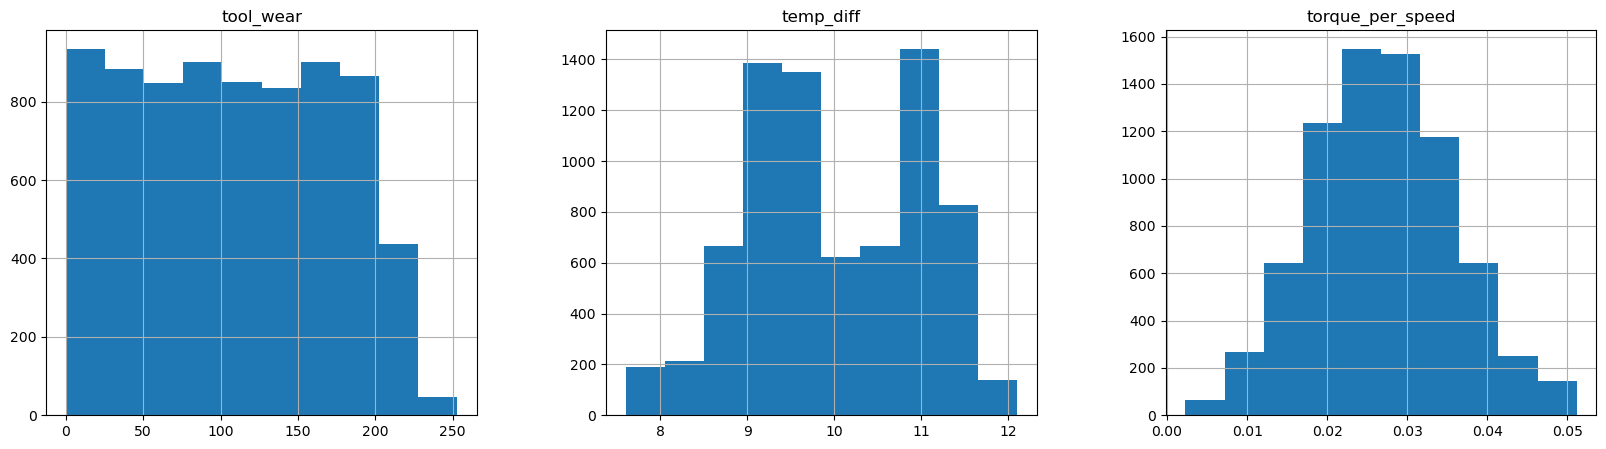

In [ ]:
# Check distributions
fig = plt.figure(figsize = (20,5))
for i, col in enumerate(['tool_wear', 'temp_diff', 'torque_per_speed']):
    ax = fig.add_subplot(1, 3, i + 1)
    X_train_logistic.hist(column = col, ax = ax)
plt.show()

In [ ]:
# Feature Scaling
logistic_preprocessor = ColumnTransformer(transformers = [
    ('type', 'passthrough', ['type']),
    ('tool_wear', RobustScaler(), ['tool_wear']),
    ('is_torque_outlier', 'passthrough', ['is_torque_outlier']),
    ('is_speed_outlier', 'passthrough', ['is_rotational_speed_outlier']),
    ('temp_diff', RobustScaler(), ['temp_diff']),
    ('torque_per_speed', RobustScaler(), ['torque_per_speed'])
])

logistic_reg_pipeline = Pipeline(steps = [
    ('preprocessor', logistic_preprocessor),
    ('classifier', LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = 42))
])

# Fit logistic model
logistic_reg_pipeline.fit(X_train_logistic, y_train)
y_pred_logistic = logistic_reg_pipeline.predict(X_test)
y_proba_logistic = logistic_reg_pipeline.predict_proba(X_test)[:,1]

In [ ]:
# Check convergence
logistic_model = logistic_reg_pipeline.named_steps['classifier']
print("Total number of iterations:{}".format(logistic_model.n_iter_[0]))

Total number of iterations:22


In [25]:
# Model evaluation
logistic_report = classification_report(y_test, y_pred_logistic)
print(logistic_report)

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2415
           1       0.15      0.82      0.26        85

    accuracy                           0.84      2500
   macro avg       0.57      0.83      0.58      2500
weighted avg       0.96      0.84      0.89      2500



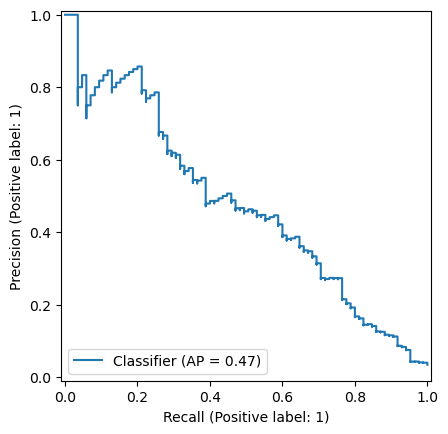

In [26]:
PrecisionRecallDisplay.from_predictions(y_test, y_proba_logistic)

Before model training, the dataset was split into a training set (75%) and a test set (25%) using stratified sampling to preserve the same proportion of failure and non-failure cases in both subsets. As stated earlier, outliers in `torque_per_speed` were capped to reduce the influence of extreme sensor readings on the logistic regression model training. The features `tool_wear`, `temp_diff `, and `torque_per_speed` were then scaled using a Robust Scaler to ensure comparable magnitudes across variables. This preprocessing helped stabilize model training and improved coefficient interpretability, particularly given the wide differences in feature scales.

To address the strong class imbalance in the target variable, class weights were assigned inversely proportional to class frequencies. The logistic regression model successfully converged and was able to detect most machine failures, though it produced a high number of false positives. The model achieved a Precision–Recall Average Precision (AP) score of 0.47, providing a reasonable baseline for comparison with more flexible and complex models.

### Random Forest Model

In [28]:
X_train_rf = X_train.copy()

q1_X_train = X_train_rf['torque_per_speed'].quantile(0.25)
q3_X_train = X_train_rf['torque_per_speed'].quantile(0.75)
IQR_X_train = q3_X_train = q1_X_train
lower_bound_X_train = q1_X_train - 1.5 * IQR_X_train
upper_bound_X_train = q1_X_train + 1.5 * IQR_X_train

X_train_rf['is_torque_per_speed_outlier'] = ((X_train_rf[['torque_per_speed']] < lower_bound_X_train) | 
                                             (X_train_rf[['torque_per_speed']] > upper_bound_X_train)).astype(int)
X_train_rf.head()

,type,tool_wear,is_torque_outlier,is_rotational_speed_outlier,temp_diff,torque_per_speed,is_torque_per_speed_outlier
9350,1,31,0,1,10.5,0.008143,0
1125,2,108,0,0,11.1,0.037382,0
2439,1,65,0,0,9.3,0.018665,0
5629,1,157,0,0,9.5,0.036584,0
2875,2,31,0,0,8.9,0.012680,0


In [29]:
X_test_rf = X_test.copy()
X_test_rf['is_torque_per_speed_outlier'] = ((X_test_rf[['torque_per_speed']] < lower_bound_X_train) | 
                                            (X_test_rf[['torque_per_speed']] > upper_bound_X_train)).astype(int)

In [ ]:
# Hyperparameter tuning
skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = True)

param_grids = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    'max_depth': [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)],
    'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 20, num = 6)],
    'min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

random_search = RandomizedSearchCV(estimator = rf,
                                   param_distributions = param_grids,
                                   n_iter = 100,
                                   scoring = 'average_precision',
                                   n_jobs = -1,
                                   cv = skfold,
                                   verbose = 3,
                                   random_state = 42)

random_search.fit(X_train_rf, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'max_depth': [10, 32, ...], 'min_samples_leaf': [1, 3, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,n_iter,100
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,3
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [31]:
y_pred_rf = random_search.best_estimator_.predict(X_test_rf)
y_proba_rf = random_search.best_estimator_.predict_proba(X_test_rf)[:,1]
print("best parameters", random_search.best_params_, '\n'
      "best PR AUC score:", average_precision_score(y_test, y_proba_rf))

best parameters {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 55} 
best PR AUC score: 0.6923373055927098


In [32]:
rf_report = classification_report(y_test, y_pred_rf)
print(rf_report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2415
           1       0.58      0.75      0.66        85

    accuracy                           0.97      2500
   macro avg       0.79      0.87      0.82      2500
weighted avg       0.98      0.97      0.97      2500



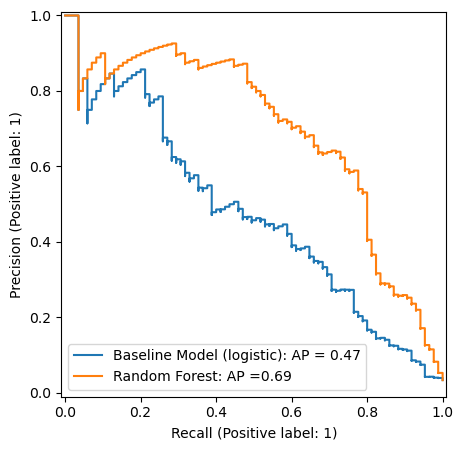

In [34]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1)
PrecisionRecallDisplay.from_predictions(y_test, y_proba_logistic, ax = ax)
PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf, ax = ax)
ax.legend(labels = [f'Baseline Model (logistic): AP = {average_precision_score(y_test, y_proba_logistic):.2f}',
                    f'Random Forest: AP ={average_precision_score(y_test, y_proba_rf):.2f}'])

For the Random Forest model, outliers in key features were identified and flagged to preserve potentially meaningful extreme values while allowing the model’s tree-based structure to handle them naturally. Flagging also provided the model with an additional signal that could improve predictive accuracy without distorting the original data distribution. Several model hyperparameters were then tuned using Stratified K-Fold cross-validation with RandomizedSearchCV to obtain reliable performance estimates and improve efficiency. The model was optimized for the Average Precision (AP) score, which effectively captures the precision–recall trade-off in the presence of class imbalance.

The optimized Random Forest model demonstrated a strong balance between precision and recall in detecting machine failures. 58% of the failure alerts raised by the model were correct, while the model successfully identified 75% of all actual failure cases. Together, these results reflect an effective trade-off between avoiding false alarms and capturing true failures, minimizing false alarms and capturing true failures, leading to a higher F1-score, AP score and overall improved detection capability. Compared with the logistic regression baseline, the Random Forest model achieved a better balance between precision and recall. In practical terms, the Random Forest model reduces unnecessary maintenance interventions (false alarms) while still detecting most potential failures early, thereby lowering maintenance costs and improving operational efficiency.


## SHAP Analysis

In [35]:
best_rf = random_search.best_estimator_
explainer = shap.TreeExplainer(best_rf)
rf_shap_values = explainer(X_test_rf)

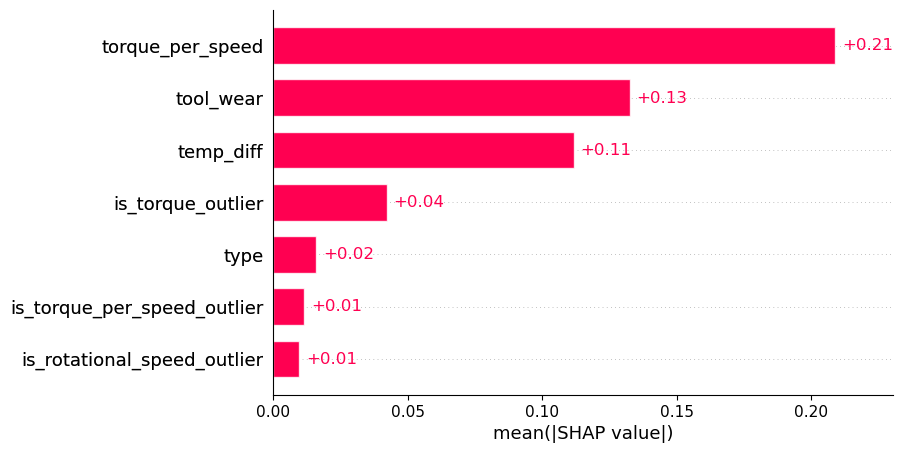

In [59]:
shap.plots.bar(rf_shap_values[:,:,1])

**Insight**
- Torque per speed is the most influential predictor in the model’s decision-making. The model strongly relies on this ratio to separate failure from non-failure cases. 
- Tool wear emerged as the second strongest predictor. This aligns with expectations that mechanical wear contributes to failures.
- Temperature difference is the third most influential predictor. The model interprets variations between process and air temperature as signals of failure risk.

Overall, predictions are primarily driven by the interaction of torque per speed, tool wear, and temperature difference, with outlier conditions serving as secondary but occasionally important signals.

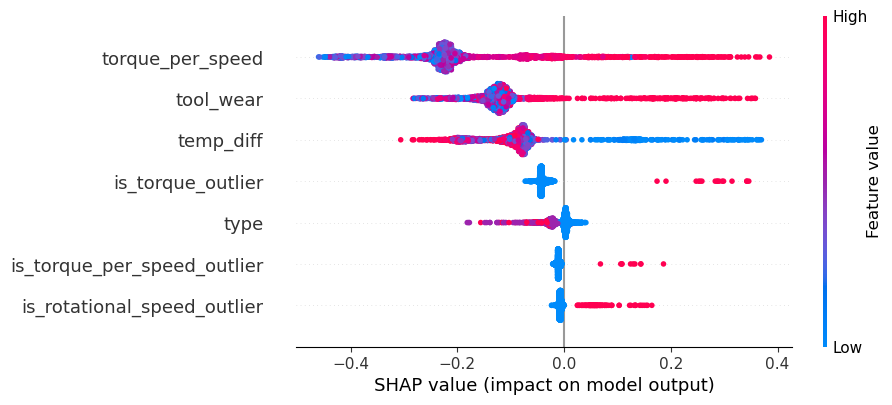

In [60]:
shap.plots.beeswarm(rf_shap_values[:,:,1])

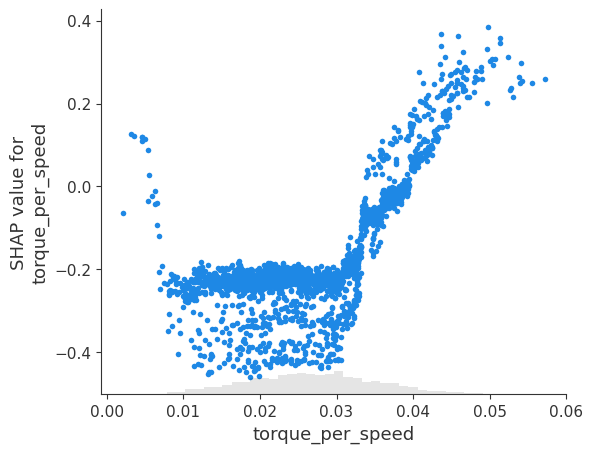

In [70]:
shap.plots.scatter(rf_shap_values[:,5,1])

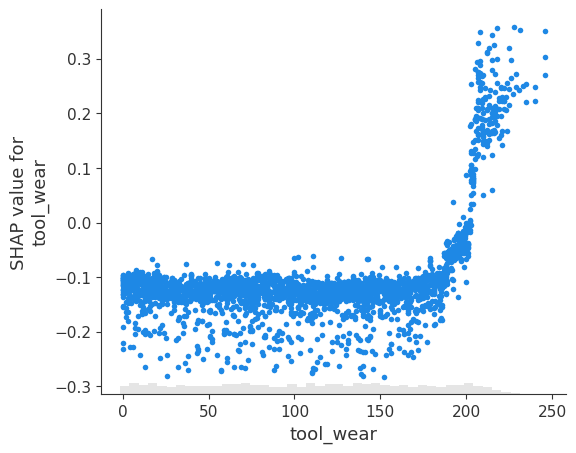

In [71]:
shap.plots.scatter(rf_shap_values[:,1,1])

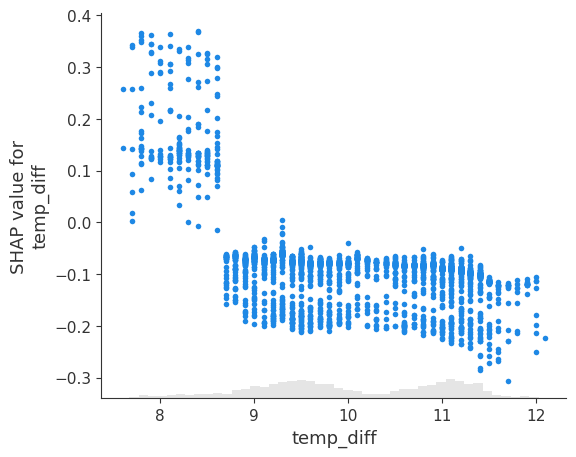

In [72]:
shap.plots.scatter(rf_shap_values[:,4,1])

**Insight**
- torque per speed
    - High torque per speed push predictions to failure while low torque per speed push predictions toward failure.
    - Some low-value points still have positive SHAP contributions, indicating failures can occur even at lower torque-speed ratios.
    - High torque relative to speed is treated as a strong predictive signal, warranting validation with engineering expertise.
- tool wear
    - Tool wear beyond a certain point significantly increases predicted failure probability.
- temp difference
    - Low temperature differences tend to push predictions toward failure and higher differences have near-zero impact.
    - This suggests that the model expects machines to operate within certain thermal patterns.
- outlier flags
    - Outlier flags have occasional positive impacts, meaning rare extreme cases can trigger failure predictions.

### Recommendation
The SHAP analysis identifies features that were most influential in the model’s predictions rather than causal factors of machine failure. Therefore, the following recommendations are model-informed insights that should be validated with engineering expertise and further operational analysis.

**Operational Recommendations**
- Torque per speed - The model consistently associates high torque per speed ratios with predicted failures, though occasional failures are also linked to low ratios. This suggests that machines operating under unusually high or low torque per speed may warrant closer monitoring or earlier inspection to prevent potential issues.
- Tool wear – Predictions indicate that higher tool wear levels are linked to elevated failure probability. Defining and monitoring wear thresholds could help trigger timely maintenance actions, subject to validation with physical wear data.
- Temperature difference – The model tends to flag lower differences between process and air temperature as risk conditions. This pattern may suggest that insufficient thermal dissipation or abnormal heat buildup contributes to failure risk, warranting further review.
- Outlier flags – Occasional positive SHAP contributions from outlier indicators suggest that extreme or rare sensor readings can influence failure predictions. These cases may merit deeper diagnostic checks to confirm whether they reflect genuine anomalies or sensor noise.

**Analytical Recommendations**
1. Collaborate with domain experts to verify whether the model’s identified relationships align with known mechanical principles.
2. Consider incorporating time-dependent features (e.g., rate of change in tool wear or torque) in future iterations to better capture gradual degradation patterns.
3. Use the Random Forest model primarily as an early warning system to flag high-risk operating conditions for preventive inspection, rather than as a definitive diagnostic tool.